In [1]:
DATA_DIRECTORY = '/home/dante/Music/clean1'

In [2]:
# https://arxiv.org/pdf/1711.10958.pdf

In [3]:
import collections
import io

import numpy as np
import pydub
import scipy
import scipy.signal
import scipy.io.wavfile


PCM_SCALARS = {
    'int32': 2**31,
    'int16': 2**15
}


def down_mix(audio):
    audio = (audio.sum(axis=1) / 2).astype(audio.dtype)
    return audio


def normalize_pcm(audio):
    pcm_scalar = PCM_SCALARS.get(audio.dtype.name, None)
    if pcm_scalar is None:
        raise MP3Error('Unkown PCM: %s' % audio.dtype)
    return audio / pcm_scalar


def mp3_hook(f):
    try:
        audio_segment = pydub.AudioSegment.from_mp3(f)
    except (OSError, pydub.exceptions.CouldntDecodeError) as err:
        raise ValueError('could not read mp3: %s' % err)
    byte_stream = io.BytesIO()
    audio_segment.export(byte_stream, 'wav')
    byte_stream.seek(0)
    return byte_stream


def read_audio(f, downmix):
    """Read wav file and return the sample rate and audio."""
    if f.suffix == '.mp3':
        f = mp3_hook(f)
    sr, audio = scipy.io.wavfile.read(f)
    if not audio.dtype is np.float32:
        audio = normalize_pcm(audio)
    if downmix and len(audio.shape) == 2:
        audio = down_mix(audio)
    return sr, audio


def spectrogram(audio, sr, **kwargs):
    f, t, Sxx = scipy.signal.spectrogram(audio, sr, **kwargs)
    # convert spectrogram to dB power
    return f, t, 10*np.log10(Sxx+1e-64)


In [4]:
import glob
import os
files = glob.glob(os.path.join(DATA_DIRECTORY, '**/*mp3'), recursive=True)
print(len(files))
files[:10]

0


[]

In [5]:
import pathlib

files = [pathlib.Path(f) for f in files]
files[:10]

[]

# Get spectrogram

In [6]:
f = files[1]
f

IndexError: list index out of range

In [7]:
sr, audio = read_audio(f, downmix=True)

NameError: name 'f' is not defined

In [8]:
#import matplotlib.pyplot as plt
#f, ax = plt.subplots(figsize=(10, 4))
#ax.plot(audio[:10*sr])

In [9]:
from IPython.display import Audio
a = Audio(audio, rate=sr)

NameError: name 'audio' is not defined

In [10]:
seconds = len(audio) / sr
seconds // 60, seconds % 60

NameError: name 'audio' is not defined

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%time f, t, Sxx = spectrogram(audio[:30*sr], sr, nfft=1024, nperseg=1024)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

NameError: name 'audio' is not defined

NameError: name 't' is not defined

In [ ]:
f.shape, t.shape, Sxx.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
f, t, Sxx = spectrogram(audio[:4*sr:2], sr=sr, nfft=512)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [12]:
f.shape, t.shape, Sxx.shape

NameError: name 'f' is not defined

In [13]:
Sxx.mean(), Sxx.std(), Sxx.min(), Sxx.max()

NameError: name 'Sxx' is not defined

In [14]:
Sxx[..., np.newaxis]

NameError: name 'Sxx' is not defined

In [15]:
np.array([Sxx[..., np.newaxis], Sxx[..., np.newaxis]]).shape

NameError: name 'Sxx' is not defined

# create training data

In [16]:
files[:5]

[]

In [17]:
import pathlib

p = pathlib.Path(files[0])
os.path.join('data', *p.parts[-3:])

IndexError: list index out of range

In [18]:
pathlib.Path('/'.join(files[0].parts[-3:]))

IndexError: list index out of range

In [19]:
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np

NFFT = 1024
SAMPLE_LENGTH_SECONDS = 30
REQUIRED_SAMPLE_RATE = 44100
EPS = REQUIRED_SAMPLE_RATE // 1000


def process_file(file):
    try:
        n_samples = REQUIRED_SAMPLE_RATE * SAMPLE_LENGTH_SECONDS
        clip1, t1 = select_clip(file, n_samples)
        clip2, t2 = select_clip(file, n_samples, position='beginning')
        clip3, t3 = select_clip(file, n_samples, position=random)
    except RuntimeError:
        pass
    except AssertionError:
        pass
    else:
        *_, Sxx1 = spectrogram(clip1, sr, nfft=NFFT, nperseg=NFFT)
        *_, Sxx2 = spectrogram(clip2, sr, nfft=NFFT, nperseg=NFFT)
        *_, Sxx3 = spectrogram(clip3, sr, nfft=NFFT, nperseg=NFFT)
        save_x(Sxx1, file, t1), save_x(Sxx2, file, t2), save_x(Sxx3, file, t3)
        save_x(Sxx2, file, t2)
    return None


def select_clip(file, n_samples, position='middle'):
    sr, audio = read_audio(file, downmix=True)

    assert sr == REQUIRED_SAMPLE_RATE
    assert n_samples <= len(audio)

    if position == 'middle':
        start = window_start(audio, n_samples)
    elif position == 'beginning':
        start = 0
    elif position == 'random':
        start = np.random.randint(len(audio) - n_samples - 1)
    else:
        raise ValueError('Invalid value for position')

    stop = start + n_samples

    return audio[start:stop + 1], (start, stop)


def window_start(audio, n_samples):
    if len(audio) // 2 > n_samples:
        return len(audio) // 2
    return 0

def save_x(x, input_file, t):
    output_subdir = pathlib.Path('/'.join(input_file.with_suffix('').parts[-3:]))
    output_dir = 'data' / output_subdir
    dest = os.path.join(output_dir, '%s-%s' % t)
    os.makedirs(output_dir, exist_ok=True)
    np.save(dest, x)
    
process_file(files[1])

if False:
    mp.Pool(mp.cpu_count() // 2).imap_unordered(process_file, tqdm(files), chunksize=20)

IndexError: list index out of range

In [22]:
import numpy as np
import os

def generate_batches(files, batch_size):
    files = files[:]

    while True:
        X = []
        X_pos = []
        X_neg = []

        # shuffle files and return copy
        np.random.shuffle(files)
        f1 = iter(files[:])
        
        while True:
            try:
                yield from generate_batch(
                    (next(f1) for _ in range(batch_size)),
                )
            except StopIteration:
                break
            except AssertionError:
                break

def generate_batch(files):
    batch = []
    ids = []

    for f in files:
        X, file_id = load_x(f)
        batch.append(X)
        ids.append(file_id)
        
    assert len(batch)
    
    X = np.array(batch)
    batch_size = len(batch)
    labels = np.array(ids)
    # add the positive examples
    X = np.concatenate([X[:, :-500, :], X[:, 500:, :]])
    labels = np.concatenate([labels, labels])

    yield X, labels

def load_x(filename):
    try:
        X = np.load(filename).T
    except ValueError:
        X = np.array([[]])
#         try:
#             X = np.load(filename, allow_pickle=True).T
#         except ValueError as err:
#             raise ValueError(filename) from err
    file_id = hash(os.path.join(*pathlib.Path(filename).parts[:-2])) % 100000
    return X, file_id

In [23]:
train_files = !find data/ -type f
len(train_files)

23599

In [24]:
%time X, labels = next(generate_batches(train_files, 32))

CPU times: user 67.1 ms, sys: 185 ms, total: 252 ms
Wall time: 631 ms


In [25]:
X.shape, labels

((64, 976, 513),
 array([39310, 11651, 22853, 25375, 77690, 38203, 10642, 56065, 90024,
        17578, 92146, 19006, 29574, 55109, 93119, 93119, 89200, 43999,
          856, 79512, 83505, 60194, 46050, 46050, 90505,  2935, 37764,
        43999,  1292, 71820, 31759, 84007, 39310, 11651, 22853, 25375,
        77690, 38203, 10642, 56065, 90024, 17578, 92146, 19006, 29574,
        55109, 93119, 93119, 89200, 43999,   856, 79512, 83505, 60194,
        46050, 46050, 90505,  2935, 37764, 43999,  1292, 71820, 31759,
        84007]))

In [26]:
X

array([[[ -70.22576735,  -59.62094994,  -56.65834765, ...,
         -151.76076536, -143.72416833, -158.19620409],
        [ -48.97194681,  -45.80603015,  -40.61621227, ...,
         -124.10654976, -123.17261715, -127.962432  ],
        [ -53.85319057,  -40.70960275,  -29.55326313, ...,
         -112.23469675, -108.01302098, -108.17533441],
        ...,
        [ -53.72371069,  -40.76144104,  -51.86576752, ...,
         -152.94016069, -142.91726733, -152.76164725],
        [ -62.29004761,  -41.97721591,  -46.3189654 , ...,
         -153.19440266, -144.89965721, -152.55601421],
        [ -86.38794809,  -38.81039232,  -41.84698805, ...,
         -145.39750514, -146.7746163 , -141.94629535]],

       [[ -50.79822683,  -35.00046024,  -25.95563649, ...,
         -112.21834998, -112.21925931, -114.94386271],
        [ -59.20407476,  -27.68763871,  -28.49653496, ...,
         -134.50803241, -135.81609477, -140.28709762],
        [ -90.59507334,  -28.65782199,  -32.82097545, ...,
         -142.

In [27]:
X.dtype, labels.dtype

(dtype('float64'), dtype('int64'))

# training

In [28]:
import tensorflow as tf
keras = tf.keras
K = keras.backend

tf.keras.backend.set_floatx('float32')
encoder = keras.models.Sequential([
    keras.layers.Input(X.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, 100, strides=15, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(32, 10, strides=1, activation='relu'),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 976, 513)          2052      
_________________________________________________________________
dense (Dense)                (None, 976, 100)          51400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 976, 100)          400       
_________________________________________________________________
conv1d (Conv1D)              (None, 59, 64)            640064    
_________________________________________________________________
batch_normalization_2 (Batch (None, 59, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0

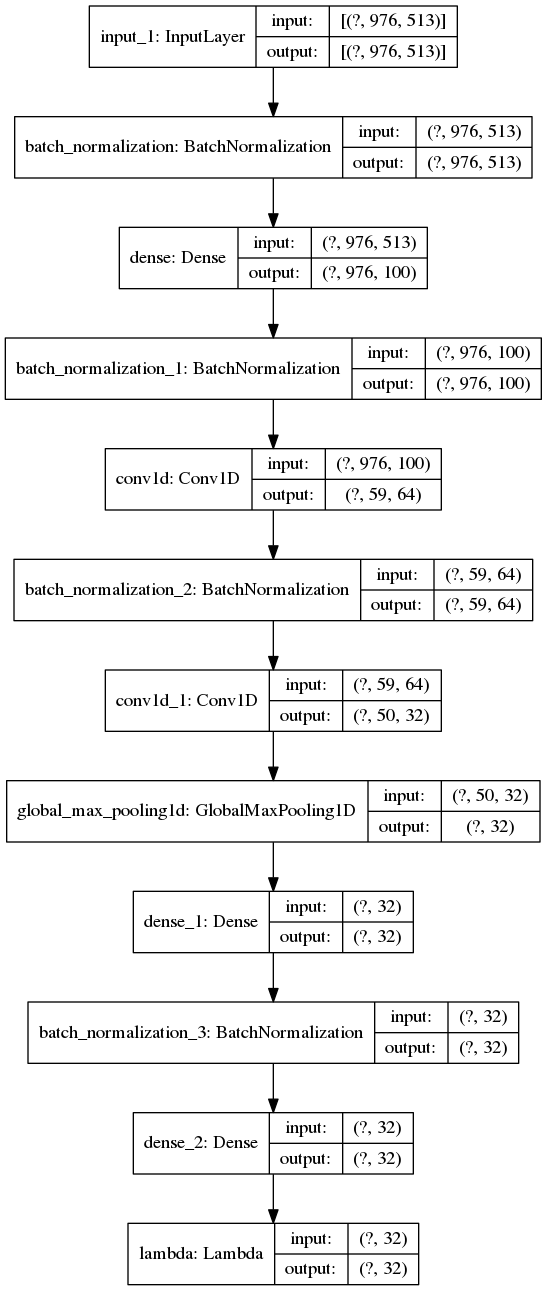

In [29]:
encoder.summary()

from IPython.display import Image

tf.keras.utils.plot_model(
    encoder,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

Image(filename='model.png')

In [30]:
import tensorflow_addons as tfa

encoder.compile(loss=tfa.losses.TripletSemiHardLoss(margin=.5), optimizer='adam')

/home/dante/venvs/python36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [31]:
# ((len(train_files) - 12) / len(train_files)) ** 64

In [32]:
BATCH_SIZE = 32

gen = generate_batches(train_files, BATCH_SIZE)
encoder.fit(
    gen,
    epochs=10,
    steps_per_epoch=len(train_files) // BATCH_SIZE,
    max_queue_size=20
)

Epoch 1/10
737/737 [==============================] - 539s 731ms/step - loss: 0.2039
Epoch 2/10
  1/737 [..............................] - ETA: 4s - loss: 0.0854

/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: generator 'generate_batches.<locals>.<genexpr>' raised StopIteration


737/737 [==============================] - 542s 736ms/step - loss: 0.1450
Epoch 3/10
737/737 [==============================] - 542s 735ms/step - loss: 0.1287
Epoch 4/10
737/737 [==============================] - 540s 732ms/step - loss: 0.1150
Epoch 5/10
737/737 [==============================] - 540s 733ms/step - loss: 0.1090
Epoch 6/10
737/737 [==============================] - 546s 741ms/step - loss: 0.1046
Epoch 7/10
737/737 [==============================] - 540s 733ms/step - loss: 0.0972
Epoch 8/10
737/737 [==============================] - 539s 731ms/step - loss: 0.0951
Epoch 9/10
737/737 [==============================] - 540s 733ms/step - loss: 0.0936
Epoch 10/10
737/737 [==============================] - 540s 732ms/step - loss: 0.0921


In [33]:
encoder.save('encoder')
# embedder.save('encoder-attention')
# import tensorflow as tf
# encoder = tf.keras.models.load_model('encoder')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: encoder/assets


In [40]:
from tqdm.notebook import tqdm

size = 100
embeddings = []
batch = []
for i, f in tqdm(enumerate(train_files, start=1), total=len(train_files)):
    batch.append(load_x(f)[0][:-500])
    if not i % size:
        batch = np.stack(batch, axis=0)
        preds = np.squeeze(encoder.predict(batch))
        assert not np.isnan(preds).any()
        embeddings.extend(preds)
        batch = []
else:
    if batch:
        batch = np.stack(batch, axis=0)
        embeddings.extend(np.squeeze(encoder.predict(batch)))

In [41]:
import pandas as pd

df = pd.DataFrame({
    'filename': train_files,
    'embedding': embeddings
})

In [42]:
df.head()

,filename,embedding
0,data/Passion Pit/Manners/09 Sleepyhead/3767627...,"[0.0, 0.0, 0.0, 0.12082751, 0.0, 0.25963706, 0..."
1,data/Passion Pit/Manners/09 Sleepyhead/3855168...,"[0.0, 0.0, 0.0, 0.10189425, 0.0, 0.29074755, 0..."
2,data/Passion Pit/Manners/08 Eyes As Candles/54...,"[0.0, 0.17401974, 0.0, 0.09892513, 0.0, 0.0, 0..."
3,data/Passion Pit/Manners/08 Eyes As Candles/25...,"[0.06992559, 0.0, 0.0, 0.34172156, 0.0, 0.0, 0..."
4,data/Passion Pit/Manners/02 Little Secrets/527...,"[0.0, 0.0, 0.0, 0.4341918, 0.0, 0.15727486, 0...."


In [43]:
train_files[0]

'data/Passion Pit/Manners/09 Sleepyhead/3767627-5090627.npy'

In [44]:
def get_part(i):
    def f(x):
        return x.split('/')[i]
    return f
df['artist'] = df.filename.apply(get_part(1))
df['album'] = df.filename.apply(get_part(2))
df['song'] = df.filename.apply(get_part(3))
df['start_stop'] = df.filename.apply(get_part(4)).str.split('.').str[0]
df['start'] = df.start_stop.str.split('-').str[0].astype(int)
df['stop'] = df.start_stop.str.split('-').str[1].astype(int)
df['mp3_filename'] = df.apply(lambda x: pathlib.Path(os.path.join(DATA_DIRECTORY, x.artist, x.album, x.song + '.mp3')), axis=1)
df['song_clean'] = df.song.apply(lambda x: ' '.join(x.split()[1:]).replace('.mp3', ''))

df.head()

,filename,embedding,artist,album,song,start_stop,start,stop,mp3_filename,song_clean
0,data/Passion Pit/Manners/09 Sleepyhead/3767627...,"[0.0, 0.0, 0.0, 0.12082751, 0.0, 0.25963706, 0...",Passion Pit,Manners,09 Sleepyhead,3767627-5090627,3767627,5090627,/home/dante/Music/clean1/Passion Pit/Manners/0...,Sleepyhead
1,data/Passion Pit/Manners/09 Sleepyhead/3855168...,"[0.0, 0.0, 0.0, 0.10189425, 0.0, 0.29074755, 0...",Passion Pit,Manners,09 Sleepyhead,3855168-5178168,3855168,5178168,/home/dante/Music/clean1/Passion Pit/Manners/0...,Sleepyhead
2,data/Passion Pit/Manners/08 Eyes As Candles/54...,"[0.0, 0.17401974, 0.0, 0.09892513, 0.0, 0.0, 0...",Passion Pit,Manners,08 Eyes As Candles,5459328-6782328,5459328,6782328,/home/dante/Music/clean1/Passion Pit/Manners/0...,Eyes As Candles
3,data/Passion Pit/Manners/08 Eyes As Candles/25...,"[0.06992559, 0.0, 0.0, 0.34172156, 0.0, 0.0, 0...",Passion Pit,Manners,08 Eyes As Candles,2532575-3855575,2532575,3855575,/home/dante/Music/clean1/Passion Pit/Manners/0...,Eyes As Candles
4,data/Passion Pit/Manners/02 Little Secrets/527...,"[0.0, 0.0, 0.0, 0.4341918, 0.0, 0.15727486, 0....",Passion Pit,Manners,02 Little Secrets,5270976-6593976,5270976,6593976,/home/dante/Music/clean1/Passion Pit/Manners/0...,Little Secrets


In [45]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

from IPython.display import Audio, display
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc
import dash_html_components as html


def rank_matches(e, embeddings):
    e = np.array([e])
    embeddings = np.array(embeddings)
    similarities = euclidean_distances(e, embeddings)
    ranks = np.argsort(similarities)
    return ranks[0]


def song_recommendations(song):
    e = df.set_index('song_clean').loc[song].embedding.iloc[0]
    ranks = rank_matches(e, np.array(df.embedding.tolist()))
    return df.iloc[ranks]


def generate_clip(f, start, stop):
    sr, audio = read_audio(f, downmix=True)
    return display(Audio(audio[start:stop], rate=sr))


def eval_recommendations(song, n):
    recs = song_recommendations(song).head(n)
    for _, r in recs.iterrows():
        print(r.artist, '-', r.song_clean), generate_clip(r.mp3_filename, r.start, r.stop)
#     app = JupyterDash(__name__)
#     app.layout = html.Div([
        
#             dbc.Table(
#                 html.Tbody([
#                     html.Tr([html.Td(r.artist), html.Td(r.song_clean), html.Div(song_clip(r.mp3_filename, r.start, r.stop))])
#                     for _, r in recs.iterrows()
#                 ])
#             )
#     ])
#     # Run app and display result inline in the notebook
#     app.run_server(mode='inline')

In [46]:
song_recommendations('Get Up Offa That Thing')

,filename,embedding,artist,album,song,start_stop,start,stop,mp3_filename,song_clean
19480,data/James Brown/20 All Time Greatest Hits/19 ...,"[0.0, 0.3520497, 0.0, 0.0, 0.0, 0.014321814, 0...",James Brown,20 All Time Greatest Hits,19 Get Up Offa That Thing,5516910-6839910,5516910,6839910,/home/dante/Music/clean1/James Brown/20 All Ti...,Get Up Offa That Thing
19481,data/James Brown/20 All Time Greatest Hits/19 ...,"[0.0, 0.3743742, 0.0, 0.0, 0.0, 0.0383785, 0.0...",James Brown,20 All Time Greatest Hits,19 Get Up Offa That Thing,8751495-10074495,8751495,10074495,/home/dante/Music/clean1/James Brown/20 All Ti...,Get Up Offa That Thing
16027,data/Tom Petty and the Heartbreaker/Southern A...,"[0.0, 0.32035276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Tom Petty and the Heartbreaker,Southern Accents,07 Dogs On The Run,4871808-6194808,4871808,6194808,/home/dante/Music/clean1/Tom Petty and the Hea...,Dogs On The Run
20145,data/Tom Petty and the Heartbreakers/Southern ...,"[0.0, 0.32035276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Tom Petty and the Heartbreakers,Southern Accents,07 Dogs On The Run,4871808-6194808,4871808,6194808,/home/dante/Music/clean1/Tom Petty and the Hea...,Dogs On The Run
16025,data/Tom Petty and the Heartbreaker/Southern A...,"[0.0, 0.3360904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01...",Tom Petty and the Heartbreaker,Southern Accents,09 The Best Of Everything,7963861-9286861,7963861,9286861,/home/dante/Music/clean1/Tom Petty and the Hea...,The Best Of Everything
...,...,...,...,...,...,...,...,...,...,...
20937,data/Rush/Snakes & Arrows/03 Workin' Them Ange...,"[0.37963125, 0.0, 0.109841526, 0.2277227, 0.34...",Rush,Snakes & Arrows,03 Workin' Them Angels,6321024-7644024,6321024,7644024,/home/dante/Music/clean1/Rush/Snakes & Arrows/...,Workin' Them Angels
7122,data/The National/Cherry Tree/07 A Reasonable ...,"[0.5785579, 0.0, 0.0, 0.35430726, 0.0, 0.0, 0....",The National,Cherry Tree,07 A Reasonable Man (I Don't Mind),8796734-10119734,8796734,10119734,/home/dante/Music/clean1/The National/Cherry T...,A Reasonable Man (I Don't Mind)
1579,data/The Beatles/Let It Be/12 Get Back/3209764...,"[0.73232526, 0.0, 0.0, 0.006843058, 0.0, 0.0, ...",The Beatles,Let It Be,12 Get Back,3209764-4532764,3209764,4532764,/home/dante/Music/clean1/The Beatles/Let It Be...,Get Back
7299,data/Coldplay/A Rush of Blood to the Head/01 P...,"[0.49770078, 0.0, 0.49740094, 0.0, 0.0, 0.0, 0...",Coldplay,A Rush of Blood to the Head,01 Politik,6996405-8319405,6996405,8319405,/home/dante/Music/clean1/Coldplay/A Rush of Bl...,Politik


In [50]:
song_recommendations('Wildflowers').head(10)

,filename,embedding,artist,album,song,start_stop,start,stop,mp3_filename,song_clean
5182,data/Tom Petty/Wildflowers/01 Wildflowers/3739...,"[0.0, 0.34225103, 0.005701338, 0.0, 0.0, 0.0, ...",Tom Petty,Wildflowers,01 Wildflowers,3739310-5062310,3739310,5062310,/home/dante/Music/clean1/Tom Petty/Wildflowers...,Wildflowers
5183,data/Tom Petty/Wildflowers/01 Wildflowers/4283...,"[0.0, 0.33853027, 0.050359644, 0.0, 0.0, 0.0, ...",Tom Petty,Wildflowers,01 Wildflowers,4283286-5606286,4283286,5606286,/home/dante/Music/clean1/Tom Petty/Wildflowers...,Wildflowers
364,data/Sufjan Stevens/Seven Swans/12 The Transfi...,"[0.0, 0.36649173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Sufjan Stevens,Seven Swans,12 The Transfiguration,7033362-8356362,7033362,8356362,/home/dante/Music/clean1/Sufjan Stevens/Seven ...,The Transfiguration
5171,data/Tom Petty/Wildflowers/03 Time To Move On/...,"[0.0, 0.3325497, 0.0712402, 0.0, 0.050801132, ...",Tom Petty,Wildflowers,03 Time To Move On,3864264-5187264,3864264,5187264,/home/dante/Music/clean1/Tom Petty/Wildflowers...,Time To Move On
13968,data/Chicago/The Best Of Chicago (40th Anniver...,"[0.0, 0.29366678, 0.039702546, 0.0, 0.0, 0.0, ...",Chicago,The Best Of Chicago (40th Anniversary Limited ...,18 Hard To Say I'm Sorry,4878930-6201930,4878930,6201930,/home/dante/Music/clean1/Chicago/The Best Of C...,Hard To Say I'm Sorry
5170,data/Tom Petty/Wildflowers/03 Time To Move On/...,"[0.0, 0.31345928, 0.075830765, 0.0, 0.05566554...",Tom Petty,Wildflowers,03 Time To Move On,4350906-5673906,4350906,5673906,/home/dante/Music/clean1/Tom Petty/Wildflowers...,Time To Move On
12905,data/Stevie Wonder/The Definitive Collection/1...,"[0.0, 0.4138034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Stevie Wonder,The Definitive Collection,13 Boogie On Reggae Woman,7130170-8453170,7130170,8453170,/home/dante/Music/clean1/Stevie Wonder/The Def...,Boogie On Reggae Woman
12906,data/Stevie Wonder/The Definitive Collection/1...,"[0.0, 0.42726254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Stevie Wonder,The Definitive Collection,13 Boogie On Reggae Woman,5553660-6876660,5553660,6876660,/home/dante/Music/clean1/Stevie Wonder/The Def...,Boogie On Reggae Woman
17884,data/Bob Dylan/The Essential Bob Dylan-/30 Thi...,"[0.0, 0.22470026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Bob Dylan,The Essential Bob Dylan-,30 Things Have Changed,6809922-8132922,6809922,8132922,/home/dante/Music/clean1/Bob Dylan/The Essenti...,Things Have Changed
10257,data/Sage Francis/A Healthy Distrust/09 Agony ...,"[0.0, 0.23495768, 0.04282755, 0.0, 0.0, 0.0, 0...",Sage Francis,A Healthy Distrust,09 Agony in Her Body,4169868-5492868,4169868,5492868,/home/dante/Music/clean1/Sage Francis/A Health...,Agony in Her Body


In [52]:
song_recommendations('Even Flow').head(10)

,filename,embedding,artist,album,song,start_stop,start,stop,mp3_filename,song_clean
5575,data/Pearl Jam/Ten/02 Even Flow/6201864-752486...,"[0.10285362, 0.0, 0.0, 0.0, 0.0, 0.13948226, 0...",Pearl Jam,Ten,02 Even Flow,6201864-7524864,6201864,7524864,/home/dante/Music/clean1/Pearl Jam/Ten/02 Even...,Even Flow
5576,data/Pearl Jam/Ten/02 Even Flow/6475392-779839...,"[0.13213898, 0.0, 0.0, 0.0, 0.0, 0.105615065, ...",Pearl Jam,Ten,02 Even Flow,6475392-7798392,6475392,7798392,/home/dante/Music/clean1/Pearl Jam/Ten/02 Even...,Even Flow
11010,data/The Yardbirds/Ultimate! Disc 1/11 I Ain't...,"[0.17484355, 0.0, 0.0, 0.11479096, 0.0, 0.1342...",The Yardbirds,Ultimate! Disc 1,11 I Ain't Got You,2373562-3696562,2373562,3696562,/home/dante/Music/clean1/The Yardbirds/Ultimat...,I Ain't Got You
9919,data/The Kinks/Face To Face/09 Most Exclusive ...,"[0.2064003, 0.0, 0.0, 0.0, 0.0, 0.2866837, 0.0...",The Kinks,Face To Face,09 Most Exclusive Residence For Sale,3723840-5046840,3723840,5046840,/home/dante/Music/clean1/The Kinks/Face To Fac...,Most Exclusive Residence For Sale
245,data/Guns 'n Roses/Appetite For Destruction/09...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.13797505, 0.068155...",Guns 'n Roses,Appetite For Destruction,09 Sweet Child o'mine,2899802-4222802,2899802,4222802,/home/dante/Music/clean1/Guns 'n Roses/Appetit...,Sweet Child o'mine
244,data/Guns 'n Roses/Appetite For Destruction/09...,"[0.16937536, 0.0, 0.0, 0.12588143, 0.0, 0.0, 0...",Guns 'n Roses,Appetite For Destruction,09 Sweet Child o'mine,7858944-9181944,7858944,9181944,/home/dante/Music/clean1/Guns 'n Roses/Appetit...,Sweet Child o'mine
14600,data/Kool & the Gang/Pulp Fiction/03 Jungle Bo...,"[0.0, 0.0, 0.0, 0.11747366, 0.0, 0.23202778, 0...",Kool & the Gang,Pulp Fiction,03 Jungle Boogie,4105152-5428152,4105152,5428152,/home/dante/Music/clean1/Kool & the Gang/Pulp ...,Jungle Boogie
252,data/Guns 'n Roses/Appetite For Destruction/12...,"[0.21845785, 0.0, 0.0, 0.023849398, 0.0, 0.177...",Guns 'n Roses,Appetite For Destruction,12 Rocket Queen,9653555-10976555,9653555,10976555,/home/dante/Music/clean1/Guns 'n Roses/Appetit...,Rocket Queen
240,data/Guns 'n Roses/Appetite For Destruction/06...,"[0.11808983, 0.0, 0.0, 0.18229093, 0.0, 0.1058...",Guns 'n Roses,Appetite For Destruction,06 Paradise City,8959104-10282104,8959104,10282104,/home/dante/Music/clean1/Guns 'n Roses/Appetit...,Paradise City
20577,data/U2/Rattle and Hum/13 Heartland/9730614-11...,"[0.07725538, 0.0, 0.0, 0.0, 0.0, 0.07614655, 0...",U2,Rattle and Hum,13 Heartland,9730614-11053614,9730614,11053614,/home/dante/Music/clean1/U2/Rattle and Hum/13 ...,Heartland


In [53]:
song_recommendations('Giant Steps').head(10)

,filename,embedding,artist,album,song,start_stop,start,stop,mp3_filename,song_clean
14040,data/John Coltrane/Giant Steps/01 Giant Steps/...,"[0.5177783, 0.0, 0.0, 0.11344608, 0.0, 0.0, 0....",John Coltrane,Giant Steps,01 Giant Steps,5164439-6487439,5164439,6487439,/home/dante/Music/clean1/John Coltrane/Giant S...,Giant Steps
14041,data/John Coltrane/Giant Steps/01 Giant Steps/...,"[0.40900028, 0.0, 0.0, 0.12546599, 0.0, 0.0, 0...",John Coltrane,Giant Steps,01 Giant Steps,6322176-7645176,6322176,7645176,/home/dante/Music/clean1/John Coltrane/Giant S...,Giant Steps
14059,data/John Coltrane/Giant Steps with Alternate ...,"[0.40900028, 0.0, 0.0, 0.12546599, 0.0, 0.0, 0...",John Coltrane,Giant Steps with Alternate Takes,01 Giant Steps,6322176-7645176,6322176,7645176,/home/dante/Music/clean1/John Coltrane/Giant S...,Giant Steps
14066,data/John Coltrane/Giant Steps with Alternate ...,"[0.45782655, 0.0, 0.0, 0.030323535, 0.0, 0.0, ...",John Coltrane,Giant Steps with Alternate Takes,02 Cousin Mary,12444991-13767991,12444991,13767991,/home/dante/Music/clean1/John Coltrane/Giant S...,Cousin Mary
16779,data/Yes/Fragile/06 Long Distance Runaround/67...,"[0.5132485, 0.0, 0.0, 0.18785371, 0.1353368, 0...",Yes,Fragile,06 Long Distance Runaround,6783571-8106571,6783571,8106571,/home/dante/Music/clean1/Yes/Fragile/06 Long D...,Long Distance Runaround
14058,data/John Coltrane/Giant Steps with Alternate ...,"[0.54870445, 0.0, 0.0, 0.12480442, 0.0, 0.0, 0...",John Coltrane,Giant Steps with Alternate Takes,01 Giant Steps,2455412-3778412,2455412,3778412,/home/dante/Music/clean1/John Coltrane/Giant S...,Giant Steps
16786,data/Yes/Fragile/04 South Side of the Sky/1051...,"[0.50736016, 0.0, 0.0, 0.03771622, 0.0, 0.0, 0...",Yes,Fragile,04 South Side of the Sky,10513152-11836152,10513152,11836152,/home/dante/Music/clean1/Yes/Fragile/04 South ...,South Side of the Sky
14063,data/John Coltrane/Giant Steps with Alternate ...,"[0.5103362, 0.0, 0.0, 0.17998382, 0.0, 0.0, 0....",John Coltrane,Giant Steps with Alternate Takes,11 Countdown [*][Alternate Take][Alternate Take],580588-1903588,580588,1903588,/home/dante/Music/clean1/John Coltrane/Giant S...,Countdown [*][Alternate Take][Alternate Take]
22385,data/Miles Davis All-Stars; Miles Davis Quinte...,"[0.5081902, 0.0, 0.0, 0.2934772, 0.0881982, 0....",Miles Davis All-Stars; Miles Davis Quintet,Walkin',03 Solar,6288192-7611192,6288192,7611192,/home/dante/Music/clean1/Miles Davis All-Stars...,Solar
22387,data/Miles Davis All-Stars; Miles Davis Quinte...,"[0.46368104, 0.049296368, 0.0, 0.30455953, 0.0...",Miles Davis All-Stars; Miles Davis Quintet,Walkin',03 Solar,9989785-11312785,9989785,11312785,/home/dante/Music/clean1/Miles Davis All-Stars...,Solar


In [ ]:
# from fuzzywuzzy import fuzz
# import wikipedia

# def display_wiki_search(names, fuzz_threshold=50):
#     print(f'{"Avail Name":50}', f'{"Wiki Page Name":50}', f'{"Fuzz ratio":50}')
#     print('-' * 103)
#     for name in names:
#         if name is np.nan:
#             continue
#         scores = search_wiki(name, fuzz_threshold)
#         if scores:
#             print(f'{name:50}', f'{scores[0][0]:50}', scores[0][1])
#         else:
#             print(f'{name:50}', f'{"Not matched":50}', '-')


# def search_wiki(name, fuzz_threshold):
#     scores = ((wiki_name, fuzz.ratio(name.lower(), wiki_name.lower()))
#               for addon in ['', ' tv show', ' tv', ' tv series']
#               for wiki_name in wikipedia.search(name + addon))
#     return [x for x in scores if x[-1] > fuzz_threshold]

In [ ]:
raise

In [ ]:
from functools import lru_cache
import json

from bs4 import BeautifulSoup
import wikipedia


if False:

    try:
        lookup_genre
    except NameError:
        @lru_cache(1000)
        def lookup_genre(artist):
            return _lookup_genre(artist)

    def _lookup_genre(artist):
        page = _fetch_page(artist)
        if not page is None:
            s = BeautifulSoup(page.html())
            try:
                return _extract_genre(s)
            except TypeError:
                pass
        return 'Unlabeled'

    def _fetch_page(artist):
        for suffix in ['', ' (Band)', ' (Musician)']:
            try:
                return wikipedia.page(artist + suffix)
            except Exception:
                pass
        return None

    def _extract_genre(s):
        for row in s.find('tbody'):
            if hasattr(row, 'th') and hasattr(row.th, 'text') and row.th.text.lower().startswith('genre'):
                try:
                    return row.findAll('a')[0].text
                except IndexError:
                    try:
                        return row.findAll('li')[0].text
                    except IndexError:
                        return 'Unlabeled'

    _lookup_genre('Jimi Hendrix')
    
    genres = {a: lookup_genre(a) for a in tqdm(df.artist.unique())}
    with open('genres.json', 'w') as f:
        json.dump(genres, f)
        
else:
    with open('genres.json') as f:
        genres = json.load(f)

In [ ]:
tuple(genres.items())[:10]

In [ ]:
df['genre'] = df.artist.map(genres)

In [ ]:
df = df[df.genre.ne('Unlabeled') & df.artist.ne('(unknown)')]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import bokeh

artist_embeddings = df.groupby(['artist', 'genre']).apply(lambda x: np.sum(x.embedding) / len(x))
xy = TSNE().fit_transform(np.stack(artist_embeddings.to_list()))

In [ ]:
artist_embeddings = artist_embeddings.reset_index().rename({0: 'embedding'}, axis=1)
artist_embeddings.head()

In [ ]:
np.array(artist_embeddings.embedding.tolist()).shape

In [ ]:

def lookup_artist(artist):
    e = artist_embeddings.set_index('artist').loc[artist].embedding
    ranks = rank_matches(e, np.array(artist_embeddings.embedding.tolist()))
    return artist_embeddings.iloc[ranks]


lookup_artist('Tom Petty')

In [59]:
artist_embeddings = artist_embeddings[artist_embeddings.artist.ne('(unknown)')]

In [60]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
from bokeh.palettes import viridis


output_notebook()

source = ColumnDataSource(
        data=dict(
            x=xy[:, 0],
            y=xy[:, 1],
            artist=artist_embeddings.artist,
            genre=artist_embeddings.genre
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("artist", "@artist"),
            ("genre", "@genre")
        ]
    )

color_map = CategoricalColorMapper(factors=artist_embeddings.genre.unique(), palette=viridis(df['genre'].nunique()))
p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Artist Embeddings")

p.circle('x', 'y', size=10, source=source, color={'field': 'genre', 'transform': color_map})

show(p)

Loading BokehJS ...